# <font color='#069af3'> Automation - Rain data for UK cities</font>

## Introduction:

In the first notebook, we retrieved the weather data for London from the Open Meteo API, we counted the rainy days for each year from 1980 to 2024 and we showed that the rain patterns can be predicted by a third order Fourier series.
<br>
<br>
Now, we want to count the rainy days for more than one UK cities and save the data into a text file, so that we can process them in the next Jupyter notebook.
<br>
<br>
The steps we will follow are:
<br>
1. Write functions to get the data from the API & count the rainy days
2. Retrieve the geograpical coordinates of every UK city from the web (webscraping)
3. Count the rainy days for multiple UK cities
4. Write the data into a file

## <font color='#069af3'>STEP 0</font>: Importing useful libraries

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

# Update issue on pandas (reading/writing df)
pd.DataFrame.iteritems = pd.DataFrame.items

# API-specific library
import openmeteo_requests

# For calling the API
import requests_cache    
import requests  

# Needed for isolating the integers from a string
import re 

# Needed for sleep command
import time 

## <font color='#069af3'>STEP 1</font>: Write functions to get the data from the API & count the rainy days

### 1a: Setup the Open-Meteo API client with cache

This is the same step as the **Step 1** in the first notebook, with the difference that we have supressed the retries when calling the API. This is because we will call the API multiple times in a loop in **Step 3** and we want to limit the number of calls as much as we can.

In [2]:
# Create cache
cache_session = requests_cache.CachedSession('.cache', expire_after = -1) 

# Create client instance
openmeteo = openmeteo_requests.Client(session = cache_session)

# URL for historical data
url_hist = "https://archive-api.open-meteo.com/v1/archive" 

### 1b: Call the API and save the weather data in a dataframe in a function

Now, we will write a function, which calls the API, retrieves the daily rain data and saves it into a dataframe format. This is (mostly) the same code as in **Step 1b**, **Step 1c** and **Step 2** of the first notebook, written altogether as a function.

In [3]:
def get_data(lat, lon, str_date, end_date, tzone, prop):
    
    # INPUTS: latitude; longitude; start date; end date; timezone; property(string)
    '''Fun to get desired data from API based on given parameters'''
    
    # STEP 1: # Dictionary containing parameters and type of requested data
    params = {
    	"latitude": lat, 
    	"longitude": lon, 
    	"start_date": str_date,
    	"end_date": end_date,
    	"daily": [prop], 
    	"timezone": tzone
    }
    
    # STEP 2: Get response from API with the given parameters
    responses = openmeteo.weather_api(url_hist, params=params)

    # Process first location (1st response)
    response = responses[0]   
    
    # STEP 3: Convert requested data into df 
    
    # 3a: Retrieve the daily data from the response 
    daily = response.Daily() 
    
    # 3b: Isolate the daily rain (array)
    daily_rain = daily.Variables(0).ValuesAsNumpy()  

    daily_data = {"date": pd.date_range(
    	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
    	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
    	freq = pd.Timedelta(seconds = daily.Interval()),
    	inclusive = "left"
    )}

    # 3c: Build dataframe using columns (based on dictionary key)
    daily_data["rain"] = daily_rain
    daily_dataframe = pd.DataFrame(data = daily_data)
    
    # OUTPUT = Dataframe with daily data
    return daily_dataframe

Now, we will test the function and check that we get the same result for London as in the first notebook:

In [4]:
# Define parameters for London
lat_Ldn = 51.5085 # latitude (London)
long_Ldn = -0.1257 # longitude (London)
str_date = "1980-07-08"  
end_date = "2024-07-28"
time_Ldn = "Europe/London" # timezone
prop = "rain_sum" # in mm


# Get dataframe using function
daily_df_LON = get_data(lat_Ldn, long_Ldn, str_date, end_date, time_Ldn, prop)

# Print dataframe
print(daily_df_LON)

                           date       rain
0     1980-07-07 23:00:00+00:00  14.700001
1     1980-07-08 23:00:00+00:00   5.700000
2     1980-07-09 23:00:00+00:00   0.000000
3     1980-07-10 23:00:00+00:00   0.600000
4     1980-07-11 23:00:00+00:00   0.900000
...                         ...        ...
16087 2024-07-23 23:00:00+00:00   0.500000
16088 2024-07-24 23:00:00+00:00   2.300000
16089 2024-07-25 23:00:00+00:00   0.000000
16090 2024-07-26 23:00:00+00:00   0.000000
16091 2024-07-27 23:00:00+00:00   0.000000

[16092 rows x 2 columns]


### 1c: Count rainy days per year and save the data into a dataframe in a function

Now, we will write a function, which counts the number of rainy days per year and saves it into a dataframe, when given the daily rain data (generated by the previous function).
<br>
Again, the code is mostly the same as in **Step 3** of the first notebook.

In [5]:
def calc_rain_days(df):
    
    # INPUT = daily dataframe
    '''Fun to calculate how many rainy days for each year'''
    
    # STEP 1: Divide into sub-dataframes: one per year
    
    # 1a: Isolate year and add it in a new column
    df['year'] = pd.to_datetime(df['date']).dt.year

    # 1b: Replace date/time with date (more readable)
    df['date'] = pd.to_datetime(df['date']).dt.date
    
    # 1c: Split into sub-df according to year
    yearly_df = [df[df['year'] == k] \
                 for k in np.unique(df['year'])]

    
    # STEP 2: Count how many days have rain > 1mm for each year
    
    # List comprehension 
    tot_rain_year = [len(np.where( (yearly_df[k]["rain"] > 1) )[0]) \
                     for k in range(0, len(yearly_df))]  


    # STEP 3: Generate new df: year; rain count per year
    rain_year_df = pd.DataFrame()
    rain_year_df["year"] = np.unique(df['year'])  # add year
    rain_year_df["rain_count"] = tot_rain_year  # add rain count


    # STEP 4: Crop first/last year (days << 365)
    df_crop = rain_year_df[1:-1]

    # OUTPUTS = yearly dataframe (cropped)
    return df_crop

Again, we want to test the function and check that we get the same result for London as in the first notebook:

Text(0.5, 1.0, 'Rainy Days per Year in London 1981-2023')

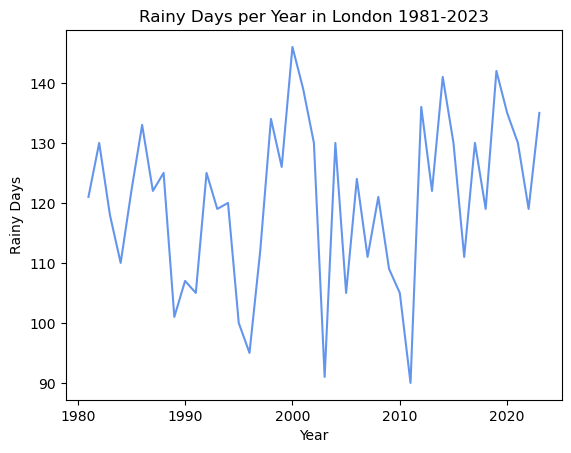

In [6]:
yr_df_LON = calc_rain_days(daily_df_LON)

# Plot to check more easily
plt.figure()
plt.plot(yr_df_LON["year"], yr_df_LON["rain_count"], color = "cornflowerblue")
plt.xlabel("Year")
plt.ylabel("Rainy Days")
plt.title("Rainy Days per Year in London 1981-2023")

## <font color='#069af3'>STEP 2</font>: Retrieve the geograpical coordinates of every UK city from the web (webscraping)

The **get_data** function we generated in **Step 1b** requires the Latitude and Longitude of the city under study to be input by the user. This is because the API needs this piece of information in order to retrieve the weather data for the correct location.
<br>
<br>
Therefore, we needed to find a way to retrieve the geogrpahical coordinates of all the cities in the UK from the web, in a fast and automated way. For this, we have used the GeoNames free geographical database: https://www.geonames.org/.
<br>
When selecting the location as the United Kingdom, it shows us the name of every UK city, along with its Latitude and Longitude in the geographic coordinate system, an example of which is shown in the following snapshot:

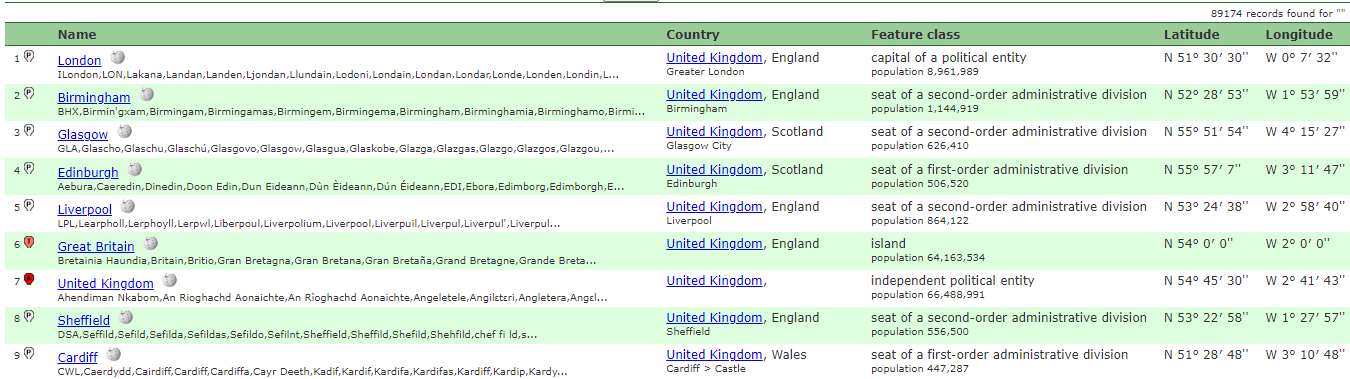


Since all the data we want is already on a table, we decided to use the ``pd.read_html`` (``pandas`` function), which extracts all of the tables from a HTML page.

_**Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html**_

### 2a: Get the city coordinates from the first page

As a first step, we scraped the coordinates from the website:

In [7]:
# URL for UK
url = "https://www.geonames.org/search.html?q=&country=GB"  
   
# Get content from URL
html = requests.get(url).content
    
# Convert content to pandas df & extract link
    
# Ignore one row; Use the 1st row as header for each column of the df 
df_page = pd.read_html(html, skiprows = 1, header = 0) 
  
# Get rid of last row of df (empty) 
df_page_cut = df_page[0].iloc[0:-1].copy()
    
# Print first row of the dataframe
print(df_page_cut.iloc[0]) 

Unnamed: 0                                                     1.0
Name             London ILondon,LON,Lakana,Landan,Landen,Ljonda...
Country                     United Kingdom, England Greater London
Feature class    capital of a political entity population 8,961...
Latitude                                            N 51° 30′ 30''
Longitude                                             W 0° 7′ 32''
Name: 0, dtype: object


### 2b: Formatting

Now, we want the "Name" column to write the name of the city only in English, to make the dataframe easy to read. For example, here we wanted to keep only "London" istead of "London ILondon,LON,Lakana,Landan,Landen,Ljonda...".
<br>
<br>
We can try to isolate only the _first word_ of the name:

In [8]:
# For London
name_Lon = df_page_cut["Name"].iloc[0]  # Full name
print("Full name:" + "    " + str(name_Lon))

Lon_1st = name_Lon.split(',')[0].split(" ")[0] # Isolate first element
print("Only first element:"  + "    " + str(Lon_1st) + "\n" + "\n")

# For Greater Manchester
name_Manc = df_page_cut["Name"].iloc[11] # Full name
print("Full name:" + "    " + str(name_Manc))

Manc_1st = name_Manc.split(',')[0].split(" ")[0] # Isolate first element
print("Only first element:"  + "    " + str(Manc_1st))

Full name:    London ILondon,LON,Lakana,Landan,Landen,Ljondan,Llundain,Lodoni,Londain,Londan,Londar,Londe,Londen,Londin,L...
Only first element:    London


Full name:    Bristol BRS,Bricgstōƿ,Briosto,Briostó,Bristo,Bristol,Bristol',Bristole,Bristolis,Bristolium,Bristolo,Briston...
Only first element:    Bristol


We can see that even though for London it works fine, this is not the case for Greater Manchester, since the name itself is made up of two words.
<br>
For this reason, we extracted the city name from the hyperlink associated with each city as follows:

In [9]:
# Extract the link of the webpage from the body of the webpage
df_page = pd.read_html(html, skiprows = 1, extract_links = "body")
  
# Input column names manually (because "Link" column name is empty)
df_page[0].columns = ['Link', 'Name', 'Country', 'Feature class', 'Latitude', 'Longitude']
  
# Get rid of 1st & last row of df (empty) 
df_page_cut = df_page[0].iloc[1:-1].copy()
    
# Print the 1st row of dataframe (only useful cols.)
print(df_page_cut[["Link", "Latitude", "Longitude"]].iloc[0])

Link         (1, /2643743/london.html)
Latitude        (N 51° 30′ 30'', None)
Longitude         (W 0° 7′ 32'', None)
Name: 1, dtype: object


Now, we need to do some more formatting to isolate the city name from the link and get rid of the "None" element from the Latitude and Longitude. This is done by splitting the elements of each row, using the ``.apply(pd.Series)`` operation and then isolating only the useful element.

In [10]:
# Initialise formatted df
df_form = pd.DataFrame()


# Split the element of each row and keep only the useful one 
df_form["Link"] = df_page_cut["Link"].apply(pd.Series)[1] # Keep 1st element
df_form["Latitude"] = df_page_cut["Latitude"].apply(pd.Series)[0] # Keep 0th element
df_form["Longitude"] = df_page_cut["Longitude"].apply(pd.Series)[0] # Keep 0th element


# Print 1st row of dataframe after formatting
print(df_form.iloc[0])
print("\n" + "\n")

    
# Isolate city name from URL (Split twice because it has "/" and then cityname.html)
df_form["Link"] = [str.split(str.split(df_form["Link"].iloc[i], "/")[2], 
                              ".")[0] for i in range(len(df_form))]

# Print final form of the df
print("Final format of dataframe:" + "\n")
print(df_form.iloc[0])  # London
print("\n" + "\n")
print(df_form.iloc[11])  # Greater Manchester

Link         /2643743/london.html
Latitude           N 51° 30′ 30''
Longitude            W 0° 7′ 32''
Name: 1, dtype: object



Final format of dataframe:

Link                 london
Latitude     N 51° 30′ 30''
Longitude      W 0° 7′ 32''
Name: 1, dtype: object



Link                bristol
Latitude     N 51° 27′ 18''
Longitude     W 2° 35′ 47''
Name: 12, dtype: object


&uarr; This is the final form of the dataframe, containing the city name in a readable manner, along with its Latitude and Longitude in the geographic coordinate system.

### 2c: Get the coordinates of all the UK cities 

However, there is another problem with the way we read the city coordinates from the website. The dataframe contains only 50 cities! This is because we have read _only_ the first page of the website.

In [11]:
print("The length of the dataframe is:" + "   " + str(len(df_form)))

The length of the dataframe is:   50


_How to scrape the content from all the pages?_
<br>
<br>
We can write a loop that scrapes the content from the entire website. The loop will read the first page, save its content in a dataframe, then go to the second page, save its content in a new dataframe and so on. The loop will stop once it reads the final page and it will then append all the page-wise dataframes into a list.
<br>
<br>
But first, we need to know which url to pass each time, since it changes for every page. We noticed that the url has a different extension for each page, of the form: startRow = nbr, with nbr being the _index_ of the first row of the page. We know that the first page contains 50 cities, one in each row, with indices running from 0 to 49. The second page starts with the 51st city, of index 50, the third page starts on index 100 and so on. We also know that the starting row of the _last_ page will have the index 5,000.
<br>
<br>
We can write the url of each page as follows:

In [12]:
# URL base
url_next_page = "https://www.geonames.org/search.html?q=&country=GB&startRow="

# Index of first row
startRow = 0   

# Index of first row of the LAST page
last_row = 5000

# Run while the first row index is smaller than the LAST page index
while (startRow <= last_row): 
    
    # URL = general expression & updated starting row
    url_page = f"{url_next_page}{startRow}" 
    
    # Print URL of this page 
    print(url_page)
    
    # Update index of starting row
    startRow += 50

https://www.geonames.org/search.html?q=&country=GB&startRow=0
https://www.geonames.org/search.html?q=&country=GB&startRow=50
https://www.geonames.org/search.html?q=&country=GB&startRow=100
https://www.geonames.org/search.html?q=&country=GB&startRow=150
https://www.geonames.org/search.html?q=&country=GB&startRow=200
https://www.geonames.org/search.html?q=&country=GB&startRow=250
https://www.geonames.org/search.html?q=&country=GB&startRow=300
https://www.geonames.org/search.html?q=&country=GB&startRow=350
https://www.geonames.org/search.html?q=&country=GB&startRow=400
https://www.geonames.org/search.html?q=&country=GB&startRow=450
https://www.geonames.org/search.html?q=&country=GB&startRow=500
https://www.geonames.org/search.html?q=&country=GB&startRow=550
https://www.geonames.org/search.html?q=&country=GB&startRow=600
https://www.geonames.org/search.html?q=&country=GB&startRow=650
https://www.geonames.org/search.html?q=&country=GB&startRow=700
https://www.geonames.org/search.html?q=&cou

Now that we have the url for each page, we can write the loop to scrape the content from all the pages of the website. However, since we are planning to use the data for a few hundreds cities, we will stop at the starting index of 300 (page 7):

In [25]:
# Initialise list of dataframes
all_df_LIST = []


# Initialise index of first row
startRow = 0   

# Start index of Page 7
page_7_idx = 300

# Run until we hit the last page
while (startRow < page_7_idx):
    
    # URL = general expression & updated starting row
    url_i = f"{url_next_page}{startRow}" 
   
    # Get content from URL
    html = requests.get(url_i).content
    
    # Convert content to pandas df and extract link
    df_i = pd.read_html(html, skiprows = 1, extract_links = "body") 
  
    # Manually input column names
    df_i[0].columns = ['Link', 'Name', 'Country', 'Feature class', 'Latitude', 'Longitude']
  
    
    # Get rid of the first and last row of df (empty) 
    df_cut = df_i[0].iloc[1:-1].copy()
    
    # Initialise formatted df
    df = pd.DataFrame()

    
    # Keep only the useful elements from tuple (only for cols of interest)
    df["Link"] = df_cut["Link"].apply(pd.Series)[1]
    df["Latitude"] = df_cut["Latitude"].apply(pd.Series)[0]
    df["Longitude"] = df_cut["Longitude"].apply(pd.Series)[0]


    # Isolate city name from URL 
    df["Link"] = [str.split(str.split(df["Link"].iloc[i], "/")[2], 
                              ".")[0] for i in range(len(df))]

    # Append df to LIST
    all_df_LIST.append(df)   
    
    # Update starting index of page
    startRow += 50
    

# Flatten list: from list of df to single df
city_coords_deg = pd.concat(all_df_LIST, axis = 0)


# Print df 
print(city_coords_deg)

             Link        Latitude      Longitude
1          london  N 51° 30′ 30''   W 0° 7′ 32''
2      birmingham  N 52° 28′ 53''  W 1° 53′ 59''
3       edinburgh   N 55° 57′ 7''  W 3° 11′ 47''
4       liverpool  N 53° 24′ 38''  W 2° 58′ 40''
5   great-britain    N 54° 0′ 0''    W 2° 0′ 0''
..            ...             ...            ...
46  isle-of-islay   N 55° 47′ 6''  W 6° 14′ 19''
47   fort-william  N 56° 48′ 59''   W 5° 6′ 43''
48     formartine   N 57° 20′ 0''   W 2° 18′ 0''
49       finchley   N 51° 36′ 3''  W 0° 11′ 42''
50        feltham  N 51° 26′ 46''  W 0° 24′ 49''

[300 rows x 3 columns]


### 2d: Convert Latitude & Longitude to decimals 

We have now gathered all the information we need from the GeoNames website, ie the city names and their geographical coordinates. Before we can request the rain data from the API, we need to convert the unit of Latitude and Longitude, from geographic coordinates to decimals.
<br>
<br>
We will use the formula:
<br>
<br>
$\text{Decimal Degrees} = \text{Degrees} + \frac{\text{minutes}}{60} + \frac{\text{seconds}}{3600}$
<br>
<br>
Also, by convention, if the latitude starts with "S", ie south, we will asign a negative sign to it. This is also true for the longitude, when it starts with "W", ie west.
<br>
So, for example, the latitude for London from N 51° 30′ 30'', it will become:

$51+ \frac{\text{30}}{60} + \frac{\text{30}}{3600} = 51.51$


_**Source**: https://www.omnicalculator.com/conversion/coordinates-converter_

In [27]:
# Initialise list with coordinates
Lat_dec_LIST = []
Long_dec_LIST = []


# Loop through the coordinates of the 300 cities
for i in range(len(city_coords_deg)):
    
    # STEP 1: Find direction (N, S, E, W) = first character
    dir_lat = str.split(city_coords_deg["Latitude"].iloc[i])[0]
    dir_long = str.split(city_coords_deg["Longitude"].iloc[i])[0]
    
    # STEP 2: Get only integers from string (remove special symbols)
    Lat_nbr = re.findall("\d+", city_coords_deg["Latitude"].iloc[i])
    Long_nbr = re.findall("\d+", city_coords_deg["Longitude"].iloc[i])

    # STEP 3:  Convert to decimals (round to 4 decimals)
    Lat_dec = round(int(Lat_nbr[0]) + int(Lat_nbr[1])/60 +  
                    int(Lat_nbr[2])/3600, 4)
    
    Long_dec = round(int(Long_nbr[0]) + int(Long_nbr[1])/60 +  
                     int(Long_nbr[2])/3600, 4)

    # STEP 4: Convert signs: If S (south) or W (West), negative
    if (dir_lat == "S"):
        Lat_dec = - Lat_dec
    
    if (dir_long == "W"):
        Long_dec = - Long_dec
   
    # STEP 5: Append to list
    Lat_dec_LIST.append(Lat_dec)
    Long_dec_LIST.append(Long_dec)

Finally, we can replace the converted coordinates in the dataframe and then print them into a text file:

In [28]:
# Replace converted coordinates in df
city_coords_deg["Latitude"] = Lat_dec_LIST
city_coords_deg["Longitude"] = Long_dec_LIST


# Write df in .txt file: City; Lat; Long
with open('City_coords.txt', 'w') as f:
    f.write(city_coords_deg.to_string(index = False, col_space = 15))

## <font color='#069af3'>STEP 3</font>: Count the rainy days for multiple UK cities

At this point, we can fulfill the goal of this notebook, which is to count the rainy days per year for multiple UK cities.
<br>
<br>
The workflow will be the following:
- Iterate over each of the 300 cities
- For each city, call the API (Open Meteo) to request the corresponding rain data, while providing the Latitude and Longitude from _city_coords_deg_, and save the information into a dataframe. This will be done by calling the first function ``get_data`` (**Step 1b**).
- Count the rainy days per year for this city, by calling the second function: ``calc_rain_days`` (**Step 1c**).
- Save the rainy days for all the cities into a text file.

In [29]:
# Create cache
cache_session = requests_cache.CachedSession('.cache', expire_after = -1) 

# Create client instance
openmeteo = openmeteo_requests.Client(session = cache_session)

### 3a: API request limits

However, when we try to call the API 300 times, we hit the minutely request limit:

In [30]:
# Initialise list of df
yr_rain_LIST = []


# Iterate through the 300 cities
for i in range(len(city_coords_deg)):
    
    # STEP 1: Call API and save data into df
    df_i = get_data(city_coords_deg["Latitude"].iloc[i], 
                    city_coords_deg["Longitude"].iloc[i], 
                    str_date, end_date, time_Ldn, prop)
        
        
    # STEP 2. Calc rainy days per year 
    rain_yr_i = calc_rain_days(df_i) 
        
    # STEP 3: Append rainy days count in list (convert to array first)
    yr_rain_LIST.append(np.array(rain_yr_i["rain_count"]))  
        

OpenMeteoRequestsError: {'error': True, 'reason': 'Minutely API request limit exceeded. Please try again in one minute.'}

_What are the API limits?_

To avoid this error, we first need to find out the minutely, hourly and daily limits of the API we are using. According to the Terms of Use of the API, we can call it up to 600 times per minute. 
<br>
However, we saw that this is not the case, since we hit the limit after making only 300 calls.

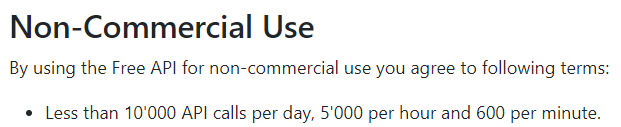

We tested when the limit is hit by printing the index of each iteration, until the error occurs:

In [32]:
# Iterate through the 300 cities
for i in range(len(city_coords_deg)):
    
    # STEP 1: Call API and save data into df
    df_i = get_data(city_coords_deg["Latitude"].iloc[i], 
                    city_coords_deg["Longitude"].iloc[i], 
                    str_date, end_date, time_Ldn, prop)
    
    # STEP 2: Print index
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


OpenMeteoRequestsError: {'reason': 'Minutely API request limit exceeded. Please try again in one minute.', 'error': True}

In this case, the limit is 45 calls per minute. However, we have noticed that the number of allowed calls heavily depends on the API traffic. After some experimentation with the limits, we decided to make 10 subsequent calls, then wait one minute, then make another 10 calls and so on.
<br>
<br>
Here, we are showing an example of this, for a total of 40 calls (ie 40 cities), which runs in approximately 5 minutes.

In [35]:
# IDX from 0 to 40 with a step of 10
idx_i = np.arange(0, 40 + 10, 10)  


# Iterates over idx_i
idx_j = np.arange(0, len(idx_i))


# List of yearly rainy days for each city
yr_rain_LIST = []   


# LOOP
for j in range(0, len(idx_j) - 1):
    
    for i in range(idx_i[j], idx_i[j+1]):
    
        # STEP 1. Build df for one city at a time
        df_i = get_data(city_coords_deg["Latitude"].iloc[i], 
                        city_coords_deg["Longitude"].iloc[i], 
                        str_date, end_date, time_Ldn, prop)
        
        
        # STEP 2. Calc rainy days per year 
        rain_yr_i = calc_rain_days(df_i)  ## need to save this!
        
        # STEP 3: Append rainy days count in list (convert to array first)
        yr_rain_LIST.append(np.array(rain_yr_i["rain_count"]))  
        
        # Print iterator i
        print(i)
        
        
    # Print "sleep statement"
    print("I'm sleeping for 1 min j =" + str(j))    
        
    # Sleep for 1 min before next iteration j
    time.sleep(60)

0
1
2
3
4
5
6
7
8
9
I'm sleeping for 1 min j =0
10
11
12
13
14
15
16
17
18
19
I'm sleeping for 1 min j =1
20
21
22
23
24
25
26
27
28
29
I'm sleeping for 1 min j =2
30
31
32
33
34
35
36
37
38
39
I'm sleeping for 1 min j =3


### 3b: Saving the data into a text file

Finally, we can save the number of rainy days per year for each of the 40 cities into a text file.
Note that we first converted the count of rainy days per year for all of the cities (_yr_rain_LIST_) into a dataframe, so that it would be easier to print all of the information into a text file at once, while also including the title of each column.

In [39]:
# STEP 1: Convert list to arr: ROW = CITY; COL = YEAR
yr_rain_ARR = np.array(yr_rain_LIST)


# STEP 2: Build df with city names and years (from arr)

# 2a: Name each column by year: 2001, 2002, ... , 2023
df_all_cities = pd.DataFrame(yr_rain_ARR, columns = yr_df_LON["year"])

# 2b: Add columns w/ city names
df_all_cities.insert(loc = 0, column = 'CITY', 
                     value = np.array(city_coords_deg["Link"].iloc[:len(yr_rain_LIST)]))

# STEP 3: Write df to file
with open('rain_40_cities.txt', 'w') as f:
    f.write(df_all_cities.to_string(index = False, col_space = 15))

### 3c: Calling the API 270 times

Below, we are showing the code that calls the API 270 times, taking in-between breaks, so that the minutely, hourly and daily request limits are not surpassed. The workflow of the loop is:

1. Call the API 10 times
2. Sleep for one minute
3. Repeat steps 1 and 2, until 60 calls are reached
4. Sleep for an hour
5. Repeat steps 1 to 4, until 270 calls are reached

<br>
We have written the rain count for these 270 cities into the file "rain_AVG_city.txt", which is where the next Jupyter notebook (Curve Fit London Rain) will read from. We have commented it out so that it will not run automatically with the whole notebook, since it takes a few hours. Note that we have changed the start date of the historical weather info to the 8th July 2000, so that we have less data to process in the next notebook.

In [31]:
'''

# IDX from 0 to len w/ step = 10
idx_i = np.arange(0, 270 + 10, 10)  


# Iterates over idx_i
idx_j = np.arange(0, len(idx_i))


# List of yearly rainy days for each city
yr_rain_LIST = []   # list of ARRAYS: 1 row = 1 city


# Start from the 8th July 2000
str_date = "2000-07-08"  


# LOOP
for j in range(0, len(idx_j) - 1):
    
    for i in range(idx_i[j], idx_i[j+1]):
    
        # STEP 1. Build df for one city at a time
        df_i = get_data(data_full["Latitude"].iloc[i], 
                        data_full["Longitude"].iloc[i], 
                        str_date, end_date, time_Ldn, prop)
        
        
        # STEP 2. Calc rainy days per year 
        rain_yr_i = calc_rain_days(df_i)  ## need to save this!
        
        # Append yearly rainy days nbr in list (+ convert to arr!)
        yr_rain_LIST.append(np.array(rain_yr_i["rain_count"]))  
        
        
    # Print "sleep statement"
    print("I'm sleeping for 1 min j =" + str(j))    
        
    # Sleep for 1 min before next iteration j
    time.sleep(60)


    # If 60 runs reached, ie if k = (j+1)/6 is integer
    if ((j+1)%6 == 0) :   
         
        print("I'm sleeping for 1 hour j =" + str(j))  
         
        time.sleep(60*60)


'''

'\n\n# IDX from 0 to len w/ step = 10\nidx_i = np.arange(0, 270 + 10, 10)  \n\n\n# Iterates over idx_i\nidx_j = np.arange(0, len(idx_i))\n\n\n# List of yearly rainy days for each city\nyr_rain_LIST = []   # list of ARRAYS: 1 row = 1 city\n\n\n\n# LOOP\nfor j in range(0, len(idx_j) - 1):\n    \n    for i in range(idx_i[j], idx_i[j+1]):\n    \n        # STEP 1. Build df for one city at a time\n        df_i = get_data(data_full["Latitude"].iloc[i], \n                        data_full["Longitude"].iloc[i], \n                        str_date, end_date, time_Ldn, prop)\n        \n        \n        # STEP 2. Calc rainy days per year \n        rain_yr_i = calc_rain_days(df_i)  ## need to save this!\n        \n        # Append yearly rainy days nbr in list (+ convert to arr!)\n        yr_rain_LIST.append(np.array(rain_yr_i["rain_count"]))  \n        \n        \n    # Print "sleep statement"\n    print("I\'m sleeping for 1 min j =" + str(j))    \n        \n    # Sleep for 1 min before next itera